In [1]:
import torch
# import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
from scipy.io import savemat, loadmat
from tqdm.notebook import tqdm, trange
# from vscode
from torch.nn import DataParallel
import csv
# from numba import njit, jit
import pandas as pd
import os
from scipy.special import rel_entr
from sklearn.metrics import mutual_info_score
from resnet50_get_relu_outputs import resnet_output
import torchvision.models as models
from torchsummary import summary
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# class TruncatedResNet(models.ResNet):
#     print("keep the structure intact")
#     def __init__(self, original_model, target_layer):
#         super(TruncatedResNet, self).__init__(
#             block=original_model.layer1[0].__class__,
#             layers=original_model.layers,
#             num_classes=original_model.fc.out_features
#         )
        
#         # Copy weights from the original model
#         self.load_state_dict(original_model.state_dict())
        
#         # Truncate the model at the target layer
#         target_modules = list(self.named_children())
#         new_model = nn.Sequential()
#         for name, module in target_modules:
#             new_model.add_module(name, module)
#             if name == target_layer:
#                 break
        
#         self.features = new_model
    
#     def forward(self, x):
#         return self.features(x)

# class FeatureExtractor(torch.nn.Module):
#     def __init__(self, original_model, layer_index):
#         super(FeatureExtractor, self).__init__()
#         self.features = torch.nn.Sequential(
#             *list(original_model.children())[:layer_index]
#         )
    
#     def forward(self, x):
#         return self.features(x)

In [4]:
def entropy(p):
    """Calculate entropy for given probability distribution."""
    p = p[p > 0]  # Filter zero probabilities to avoid log(0)
    return -np.sum(p * np.log(p))

def mutual_information(x, y, bins=120):
    """Estimate mutual information for continuous variables."""
    c_xy = np.histogram2d(x, y, bins)[0]
    p_xy = c_xy / np.sum(c_xy)  # Joint probability distribution
    p_x = np.sum(p_xy, axis=1)  # Marginal for x
    p_y = np.sum(p_xy, axis=0)  # Marginal for y
    
    # Calculate entropies
    h_x = entropy(p_x)
    h_y = entropy(p_y)
    h_xy = entropy(p_xy.flatten())
    
    # Mutual information
    mi = h_x + h_y - h_xy
    return mi


def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [5]:
# header = ['epoch', 'channel','value']
# name = "ce"
# folder_header = "/home/sarvagya/Desktop/BCH/"+name+"/"
# csv_file = "data_"+name+".csv"
# temp_mat = "tempmatrix_"+name+".mat"
# with open(folder_header+csv_file, 'w') as f:
#     writer = csv.writer(f)
#     writer.writerow(header)
    
uae_data = {
    "sub":[],
    "ses": [],
    "image": [],
    "UAE":[],
    # "energy_map":[]
}
# print(torch.cuda.get_device_name(0))

In [6]:
img_list = []
# folder = "/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/THS_images"
folder = "/media/sarvagya-pc/2TB HDD/Balgrist/full_MPM_images/wp1"
subs = sorted(os.listdir(folder))
# subs.pop(-1)
# for sub in subs:
#     sessions = sorted([ses for ses in os.listdir(folder+sub+'/') if "ses-" in ses])
#     for ses in sessions:

# print(img_list)
print(subs)

['BCA-001', 'BCA-002', 'BSL-001', 'BSL-002', 'BSL-003', 'BSL-004', 'BSL-005', 'BSL-006', 'HDG-002', 'HDG-004', 'HDG-006', 'HDG-007', 'HDG-008', 'HDG-009', 'HDG-011', 'HDG-012', 'HDG-014', 'HDG-015', 'HDG-018', 'HLE-003', 'HLE-004', 'HLE-005', 'HLE-006', 'HLE-007', 'HLE-008', 'HLE-011', 'HLE-012', 'HLE-014', 'HLE-015', 'HLE-016', 'MNU-001', 'MNU-002', 'MNU-004', 'MNU-005', 'MNU-007', 'MNU-008', 'MNU-009', 'MNU-011', 'MNU-014', 'MNU-015', 'MNU-016', 'MNU-017', 'MNU-019', 'MNU-021', 'NTL-001', 'NTL-002', 'NTL-004', 'NTL-005', 'NTL-008', 'NTL-009', 'NTL-010', 'NTL-011', 'NTL-012', 'NTL-013', 'NTL-014', 'NTL-015', 'ZRH-001', 'ZRH-003', 'ZRH-004', 'ZRH-005', 'ZRH-006', 'ZRH-007', 'ZRH-008']


In [7]:
# files_images = []
# for root, dirs, files in os.walk(os.path.abspath(folder)):
#     for file in files:
#         files_images.append(os.path.join(root, file))
# print(len(files_images))

In [8]:
# img = plt.imread("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/images/BSL-002/ses-03/axial/"+img_list[90])
# print(img[:,:,0:3].shape)
# plt.imshow(img[:,:,0:3])


In [9]:
# plt.imshow(img)

In [10]:
def energy_map(f_map):
  map = np.zeros((f_map.shape[1], f_map.shape[2]))
  for i in range(f_map.shape[0]):
    map = map + f_map[i]
  map = map/f_map.shape[0]
  return map

# @jit
# def uae(f_map):
#   f_map = f_map[0]
#   value=0
#   value+=np.sum(f_map)
#   return value/(f_map.shape[0]*f_map.shape[1]*f_map.shape[2])
def uae(f_map):
    return torch.mean(f_map[0])

In [11]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16',pretrained=True)
model_resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
model_resnet = model_resnet.to(device)
model_resnet.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
# model_test = truncate_model_to_relu(model, relu_name[1])
# model_test = TruncatedResNet(model, relu_name[2])
# model_resnet.layer4[1].conv3.register_forward_hook
# summary(model_test, input_size=(3, 155, 123))
# model

This next cell is for VGG16 model. For other models, use the next cell

In [13]:
# layers = [2,4,7,9,12,14,16,19,21,23,26,28,30]

value = []
idx = []
e_map = []
count = 0
# high.start_counters([events.PAPI_FP_OPS,])
# high.
for i in tqdm(range(len(subs))):
  # for j in range(channel):
    # img = mat['newmatrix'][i,j,:,:,:]
  sub = subs[i]
  sessions = sorted([ses for ses in os.listdir(folder+'/'+sub+'/') if "ses-" in ses])
  for ses in sessions:
    image_list = sorted(os.listdir(folder+'/'+sub+'/'+ses+'/axial'))
    for img_list in image_list:
      img = plt.imread(folder+'/'+sub+'/'+ses+'/axial/'+img_list)
      # print(img.shape)
      img = img[:,:,0:3]
      # img = rgb2gray(img)
      # img = np.rot90(img)
      img = (img-np.min(img))/(np.max(img)-np.min(img))
      # img = img.reshape(-1,img.shape[2],img.shape[0],img.shape[1])
      img = img.reshape(1, 3, img.shape[0],img.shape[1])
      print(img.shape)
      img = torch.tensor(img, dtype=torch.float32)
      # img.to(device)

      for k in range(len(relu_name)):
        model_test = truncate_model_to_relu(model, relu_name[k])
        print(model_test)
          # model_test = DataParallel(model_test, device_ids=[0, 1])
          # print(model_test.device_ids)
        img = img.cuda()
        res = model_test(img)
        res = res.cpu().detach().numpy()
        # print(res.shape)
        # temp_uae = uae(res)
        value.append(uae(res))
        print(uae(res))
        # idx.append(img_list[i])
        res = np.squeeze(res)
        res_energy = energy_map(res)
        # e_map.append(res_energy)
          # matrix_feature[i,j,:,:] = res_energy
        # idx = [i,j,value]
        # with open(folder_header+csv_file, 'a') as f:
        #   writer = csv.writer(f)
        #   writer.writerow(idx)
        # value = []
        # idx = []
      uae_data["image"].append(img_list)
      uae_data["sub"].append(sub)
      uae_data["ses"].append(ses)
      uae_data["UAE"].append(value)
      # uae_data["energy_map"].append(e_map)

      value = []
      e_map = []
    count+=1
    print(count)

# x=high.stop_counters()

  0%|          | 0/63 [00:00<?, ?it/s]

(1, 3, 155, 123)


NameError: name 'relu_name' is not defined

This cell is for resnet type models

In [ ]:
# uae_data = {
#     "sub":[],
#     "ses": [],
#     "image": [],
#     "UAE":[],
# }
# value = []
# idx = []
# e_map = []
# count = 0
# # high.start_counters([events.PAPI_FP_OPS,])
# # high.
# for i in tqdm(range(len(subs))):
#   # for j in range(channel):
#     # img = mat['newmatrix'][i,j,:,:,:]
#   sub = subs[i]
#   print(sub)
#   sessions = sorted([ses for ses in os.listdir(folder+'/'+sub+'/') if "ses-" in ses])
#   for ses in sessions:
#     # print(ses)
#     image_list = sorted(os.listdir(folder+'/'+sub+'/'+ses+'/axial'))
#     # print(len(image_list))
#     for j in tqdm(trange(len(image_list))):
#       # print(j)
#       img_list = image_list[j]
#       img = plt.imread(folder+'/'+sub+'/'+ses+'/axial/'+img_list)
#       # print(img.shape)
#       img = img[:,:,0:3]
#       # img = rgb2gray(img)
#       # img = np.rot90(img)
#       img = (img-np.min(img))/(np.max(img)-np.min(img))
#       # img = img.reshape(-1,img.shape[2],img.shape[0],img.shape[1])
#       img = img.reshape(1, 3, img.shape[0],img.shape[1])
#       # print(img.shape)
#       img = torch.tensor(img, dtype=torch.float32)
#       # img.to(device)
        
#       img = img.cuda()
#       activation_output, relu_names = resnet_output(model_resnet, img)
#       # print(len(activation_output))
#       # print((activation_output['relu']).shape)
#     #   res = res.cpu().detach().numpy()
#     #   # print(res.shape)
#     #   # temp_uae = uae(res)
#       for name in relu_names:
#         res = activation_output[name]
#         # print(uae(res))
#         value.append(uae(res))
#     #   print(uae(res))
#     #   # idx.append(img_list[i])
#         # res = np.squeeze(res)
#         # res_energy = energy_map(res)
#         # e_map.append(res_energy)
#     #     # matrix_feature[i,j,:,:] = res_energy
#     #   # idx = [i,j,value]
#     #   # with open(folder_header+csv_file, 'a') as f:
#     #   #   writer = csv.writer(f)
#     #   #   writer.writerow(idx)
#     #   # value = []
#     #   # idx = []
#       uae_data["image"].append(img_list)
#       uae_data["sub"].append(sub)
#       uae_data["ses"].append(ses)
#       uae_data["UAE"].append(value)
#     #   # uae_data["energy_map"].append(e_map)

#       value = []
#       # e_map = []
#     # count+=1
#     # print(count)

  0%|          | 0/63 [00:00<?, ?it/s]

BCA-001


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
uae_data = {
    "sub":[],
    "ses": [],
    "image": [],
    "UAE":[],
}

In [ ]:
def process_image(file_path):
    img = plt.imread(file_path)
    img = img[:,:,:3]  # Ensure 3 channels
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return torch.tensor(img.transpose(2, 0, 1).reshape(1, 3, *img.shape[:2]), dtype=torch.float32).cuda()

def process_subject(sub, folder, model_resnet, uae_function, output_folder):
    uae_data = {
        "sub": [],
        "ses": [],
        "image": [],
        "UAE": []
    }
    sessions = sorted([ses for ses in os.listdir(os.path.join(folder, sub)) if ses.startswith("ses-")])
    
    total_images = sum(len(os.listdir(os.path.join(folder, sub, ses, 'axial'))) for ses in sessions)
    
    with tqdm(total=total_images, desc=f"Processing {sub}", leave=False) as pbar:
        for ses in sessions:
            image_list = sorted(os.listdir(os.path.join(folder, sub, ses, 'axial')))
            
            for img_list in image_list:
                img_path = os.path.join(folder, sub, ses, 'axial', img_list)
                img = process_image(img_path)
                
                activation_output, relu_names = resnet_output(model_resnet, img)
                uae_values = [uae_function(activation_output[name]).detach().cpu().numpy() for name in relu_names]
                
                uae_data["sub"].append(sub)
                uae_data["ses"].append(ses)
                uae_data["image"].append(img_list)
                uae_data["UAE"].append(uae_values)
                
                pbar.update(1)
    
    # Save the data for this subject
    output_filename = f"{sub}_{ses}_wp1_resnet.mat"
    output_path = os.path.join(output_folder, output_filename)
    savemat(output_path, uae_data)
    
    return uae_data

# Main execution
# folder = "your_input_folder_path"
output_folder = "/media/sarvagya-pc/2TB HDD/Balgrist/full_MPM_images/mat_files"
os.makedirs(output_folder, exist_ok=True)

subs = sorted([sub for sub in os.listdir(folder) if os.path.isdir(os.path.join(folder, sub))])

all_uae_data = []

with tqdm(total=len(subs), desc="Processing subjects") as pbar:
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        future_to_sub = {executor.submit(process_subject, sub, folder, model_resnet, uae, output_folder): sub for sub in subs}
        
        for future in as_completed(future_to_sub):
            all_uae_data.extend(future.result().values())
            pbar.update(1)

# If you still want the combined data at the end:
uae_data = {key: [item for sublist in all_uae_data for item in sublist] for key in ["sub", "ses", "image", "UAE"]}

Processing subjects:   0%|          | 0/63 [00:00<?, ?it/s]

Processing BCA-001:   0%|          | 0/298 [00:00<?, ?it/s]

Processing BCA-002:   0%|          | 0/298 [00:00<?, ?it/s]

Processing HDG-002:   0%|          | 0/298 [00:00<?, ?it/s]

Processing BSL-006:   0%|          | 0/298 [00:00<?, ?it/s]

Processing BSL-004:   0%|          | 0/298 [00:00<?, ?it/s]

Processing BSL-001:   0%|          | 0/298 [00:00<?, ?it/s]

Processing HDG-011:   0%|          | 0/298 [00:00<?, ?it/s]

Processing BSL-002:   0%|          | 0/447 [00:00<?, ?it/s]

Processing HDG-009:   0%|          | 0/298 [00:00<?, ?it/s]

Processing HLE-003:   0%|          | 0/447 [00:00<?, ?it/s]

Processing HDG-018:   0%|          | 0/298 [00:00<?, ?it/s]

Processing HDG-006:   0%|          | 0/447 [00:00<?, ?it/s]

Processing HDG-015:   0%|          | 0/298 [00:00<?, ?it/s]

Processing HDG-007:   0%|          | 0/298 [00:00<?, ?it/s]

Processing HDG-008:   0%|          | 0/447 [00:00<?, ?it/s]

Processing HLE-007:   0%|          | 0/298 [00:00<?, ?it/s]

Processing BSL-005:   0%|          | 0/447 [00:00<?, ?it/s]

Processing HDG-014:   0%|          | 0/447 [00:00<?, ?it/s]

Processing HDG-012:   0%|          | 0/447 [00:00<?, ?it/s]

Processing HDG-004:   0%|          | 0/447 [00:00<?, ?it/s]

Processing BSL-003:   0%|          | 0/447 [00:00<?, ?it/s]

Processing HLE-006:   0%|          | 0/298 [00:00<?, ?it/s]

Processing HLE-005:   0%|          | 0/447 [00:00<?, ?it/s]

Processing HLE-004:   0%|          | 0/447 [00:00<?, ?it/s]

Processing HLE-011:   0%|          | 0/447 [00:00<?, ?it/s]

Processing HLE-008:   0%|          | 0/298 [00:00<?, ?it/s]

Processing HLE-012:   0%|          | 0/447 [00:00<?, ?it/s]

Processing HLE-014:   0%|          | 0/298 [00:00<?, ?it/s]

Processing HLE-015:   0%|          | 0/447 [00:00<?, ?it/s]

Processing HLE-016:   0%|          | 0/447 [00:00<?, ?it/s]

Processing MNU-002:   0%|          | 0/447 [00:00<?, ?it/s]

Processing MNU-004:   0%|          | 0/447 [00:00<?, ?it/s]

Processing MNU-001:   0%|          | 0/447 [00:00<?, ?it/s]

Processing MNU-005:   0%|          | 0/447 [00:00<?, ?it/s]

Processing MNU-007:   0%|          | 0/447 [00:00<?, ?it/s]

Processing MNU-008:   0%|          | 0/298 [00:00<?, ?it/s]

Processing MNU-009:   0%|          | 0/298 [00:00<?, ?it/s]

Processing MNU-011:   0%|          | 0/298 [00:00<?, ?it/s]

Processing MNU-014:   0%|          | 0/447 [00:00<?, ?it/s]

Processing MNU-015:   0%|          | 0/298 [00:00<?, ?it/s]

Processing MNU-016:   0%|          | 0/298 [00:00<?, ?it/s]

Processing MNU-017:   0%|          | 0/298 [00:00<?, ?it/s]

Processing MNU-019:   0%|          | 0/447 [00:00<?, ?it/s]

Processing MNU-021:   0%|          | 0/447 [00:00<?, ?it/s]

Processing NTL-001:   0%|          | 0/447 [00:00<?, ?it/s]

Processing NTL-002:   0%|          | 0/298 [00:00<?, ?it/s]

Processing NTL-004:   0%|          | 0/447 [00:00<?, ?it/s]

Processing NTL-005:   0%|          | 0/447 [00:00<?, ?it/s]

Processing NTL-008:   0%|          | 0/447 [00:00<?, ?it/s]

Processing NTL-009:   0%|          | 0/447 [00:00<?, ?it/s]

Processing NTL-010:   0%|          | 0/447 [00:00<?, ?it/s]

Processing NTL-011:   0%|          | 0/447 [00:00<?, ?it/s]

Processing NTL-012:   0%|          | 0/447 [00:00<?, ?it/s]

Processing NTL-013:   0%|          | 0/447 [00:00<?, ?it/s]

Processing NTL-014:   0%|          | 0/447 [00:00<?, ?it/s]

Processing NTL-015:   0%|          | 0/447 [00:00<?, ?it/s]

Processing ZRH-001:   0%|          | 0/298 [00:00<?, ?it/s]

Processing ZRH-003:   0%|          | 0/298 [00:00<?, ?it/s]

Processing ZRH-004:   0%|          | 0/447 [00:00<?, ?it/s]

Processing ZRH-005:   0%|          | 0/447 [00:00<?, ?it/s]

Processing ZRH-006:   0%|          | 0/447 [00:00<?, ?it/s]

Processing ZRH-007:   0%|          | 0/447 [00:00<?, ?it/s]

Processing ZRH-008:   0%|          | 0/447 [00:00<?, ?it/s]

In [11]:
print(folder)

/media/sarvagya-pc/2TB HDD/Balgrist/full_MPM_images/wp1


THIS IS TO CREATE AVG MAT FILE FOR UAE VALUES

In [44]:
savemat("/home/sarvagya-pc/Desktop/full_MPM_images/complete_uae_data_norm_MPM_wp2.mat", uae_data)
# data_mat_ses_1 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/BSL-002_ses-01.mat")
# data_mat_ses_2 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/BSL-002_ses-02.mat")
# data_mat_pat_2_ses_1 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/NTL-008_ses-01.mat")
# data_mat_pat_2_ses_2 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/NTL-008_ses-02.mat")
# data_mat_pat_3_ses_1 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/ZRH-004_ses-01.mat")
# data_mat_pat_3_ses_2 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/ZRH-004_ses-02.mat")
# uae_data = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/complete_uae_data.mat")
data_mat = uae_data

In [45]:
# uae_values_ses_1 = data_mat_ses_1["UAE"].squeeze()
# uae_values_ses_1 = np.round(uae_values_ses_1, decimals=4)

# uae_values_ses_2 = data_mat_ses_2["UAE"].squeeze()
# uae_values_ses_2 = np.round(uae_values_ses_2, decimals=4)

# uae_values_pat_1_ses_1 = data_mat_pat_2_ses_1["UAE"].squeeze()
# uae_values_pat_1_ses_1 = np.round(uae_values_pat_1_ses_1, decimals=4)

# uae_values_pat_1_ses_2 = data_mat_pat_2_ses_2["UAE"].squeeze()
# uae_values_pat_1_ses_2 = np.round(uae_values_pat_1_ses_2, decimals=4)

# uae_values_pat_2_ses_1 = data_mat_pat_3_ses_1["UAE"].squeeze()
# uae_values_pat_2_ses_1 = np.round(uae_values_pat_2_ses_1, decimals=4)

# uae_values_pat_2_ses_2 = data_mat_pat_3_ses_2["UAE"].squeeze()
# uae_values_pat_2_ses_2 = np.round(uae_values_pat_2_ses_2, decimals=4)
# print(np.unique(uae_data["UAE"]))
print(len(uae_data["UAE"]))
uae_data["UAE"] = np.array(uae_data["UAE"])
uae_data["UAE"].reshape(len(uae_data["UAE"]), 13)
print(uae_data["UAE"].shape)

24585
(24585, 13)


In [46]:
matrices = {}
for sub in np.unique(uae_data["sub"]):
    print(sub)
    idx_sub = np.where(np.array(uae_data["sub"]) == sub)[0]
    print(idx_sub[0], idx_sub[-1])
    sessions = np.unique(uae_data["ses"][idx_sub[0]:idx_sub[-1]+1])
    print(sessions)
    new_dict_for_each_sub = {key: values[idx_sub[0]:idx_sub[-1]+1] for key, values in data_mat.items()}

    for ses in sessions:

        idx_ses = np.where(np.array(new_dict_for_each_sub["ses"]) == ses)[0]

        new_dict_for_each_ses_for_above_sub = {key: values[idx_ses[0]:idx_ses[-1]+1] for key, values in new_dict_for_each_sub.items()}

        exec(sub.split("-")[0]+sub.split("-")[1][-1]+ses.split("-")[0]+"_"+ses.split("-")[1]+" = []")
        print(sub.split("-")[0]+sub.split("-")[1][-1]+ses.split("-")[0]+"_"+ses.split("-")[1])

        # exec(sub.split("-")[0]+ses.split("-")[0]+"_"+ses.split("-")[1]+".append()")

        print(new_dict_for_each_ses_for_above_sub["UAE"].shape)
        matrix_key = f'matrix_{sub.split("-")[0]+sub.split("-")[1][-1]+ses.split("-")[0]+"_"+ses.split("-")[1]}'
        matrices[matrix_key] = new_dict_for_each_ses_for_above_sub["UAE"]


BCA-001
0 297
['ses-01' 'ses-03']
BCA1ses_01
(149, 13)
BCA1ses_03
(149, 13)
BCA-002
298 595
['ses-02' 'ses-03']
BCA2ses_02
(149, 13)
BCA2ses_03
(149, 13)
BSL-001
596 893
['ses-02' 'ses-03']
BSL1ses_02
(149, 13)
BSL1ses_03
(149, 13)
BSL-002
894 1340
['ses-01' 'ses-02' 'ses-03']
BSL2ses_01
(149, 13)
BSL2ses_02
(149, 13)
BSL2ses_03
(149, 13)
BSL-003
1341 1787
['ses-01' 'ses-02' 'ses-03']
BSL3ses_01
(149, 13)
BSL3ses_02
(149, 13)
BSL3ses_03
(149, 13)
BSL-004
1788 2085
['ses-01' 'ses-02']
BSL4ses_01
(149, 13)
BSL4ses_02
(149, 13)
BSL-005
2086 2532
['ses-01' 'ses-02' 'ses-03']
BSL5ses_01
(149, 13)
BSL5ses_02
(149, 13)
BSL5ses_03
(149, 13)
BSL-006
2533 2830
['ses-01' 'ses-03']
BSL6ses_01
(149, 13)
BSL6ses_03
(149, 13)
HDG-002
2831 3128
['ses-01' 'ses-02']
HDG2ses_01
(149, 13)
HDG2ses_02
(149, 13)
HDG-004
3129 3575
['ses-01' 'ses-02' 'ses-03']
HDG4ses_01
(149, 13)
HDG4ses_02
(149, 13)
HDG4ses_03
(149, 13)
HDG-006
3576 4022
['ses-01' 'ses-02' 'ses-03']
HDG6ses_01
(149, 13)
HDG6ses_02
(149, 13)


In [48]:
matrix_sub = list(matrices.keys())
matrices_probability = {}

for i in range(len(matrix_sub)):

    print(matrix_sub[i])

    test_matrix = matrices[matrix_sub[i]]
    print(test_matrix.shape)

    uae_values_ses = np.round(test_matrix, decimals=4)
    print(uae_values_ses)
    print(uae_values_ses.shape)

    for i in range(test_matrix.shape[1]):

        print(uae_values_ses[:,i].shape)

        unique_ses, counts_ses = np.unique(uae_values_ses[:,i], return_counts=True)

        pdf_ses = counts_ses/counts_ses.shape[0]

        # print(pdf_ses)
        # print(pdf_ses.shape)

    # matrix_key = f'matrix_{matrix_sub[i]+"_probability"}'
    # matrices_probability[matrix_key] = 

matrix_BCA1ses_01
(149, 13)
[[0.1789 0.1491 0.2974 ... 0.1164 0.0703 0.0236]
 [0.1791 0.1508 0.3018 ... 0.1131 0.0695 0.0231]
 [0.179  0.1506 0.3016 ... 0.1225 0.0736 0.0276]
 ...
 [0.1818 0.1608 0.3206 ... 0.1314 0.0815 0.0229]
 [0.1817 0.1608 0.3199 ... 0.13   0.0847 0.0228]
 [0.1819 0.1607 0.3181 ... 0.1344 0.0768 0.0215]]
(149, 13)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
matrix_BCA1ses_03
(149, 13)
[[0.1789 0.1491 0.2974 ... 0.1164 0.0703 0.0236]
 [0.1791 0.1508 0.3018 ... 0.1131 0.0694 0.023 ]
 [0.179  0.1506 0.3016 ... 0.1226 0.0736 0.0277]
 ...
 [0.1818 0.1608 0.3206 ... 0.1313 0.0814 0.0229]
 [0.1817 0.1608 0.3198 ... 0.1298 0.0844 0.0227]
 [0.1819 0.1606 0.3181 ... 0.1343 0.0768 0.0215]]
(149, 13)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
(149,)
matrix_BCA2ses_02
(149, 13)
[[0.1791 0.1484 0.2972 ... 0.1217 0.0658 0.0216]
 [0.1792 0.1484 0.2978 ... 0.1179 0.0634 0.0214]
 [0.1791 0.148  

In [31]:
len(matrix_sub)

126

In [2]:
matrix_sub = list(matrices.keys())
num_matrices = len(matrix_sub)
mi_matrix = np.zeros((num_matrices, num_matrices, 13))
print(matrix_sub)

for i in range(len(matrix_sub)):
    print(matrix_sub[i])
    for j in range(i, len(matrix_sub)):
        for k in range(13):
            mi = mutual_information(matrices[matrix_sub[i]][:,k], matrices[matrix_sub[j]][:,k], 1000)
            mi_matrix[i, j, k] = mi
            mi_matrix[j, i, k] = mi  # Fill both (i, j) and (j, i) since MI is symmetric



# print(temp_x)

NameError: name 'matrices' is not defined

In [1]:
mi_matrix.shape

NameError: name 'mi_matrix' is not defined

/tmp/ipykernel_13797/2326633464.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


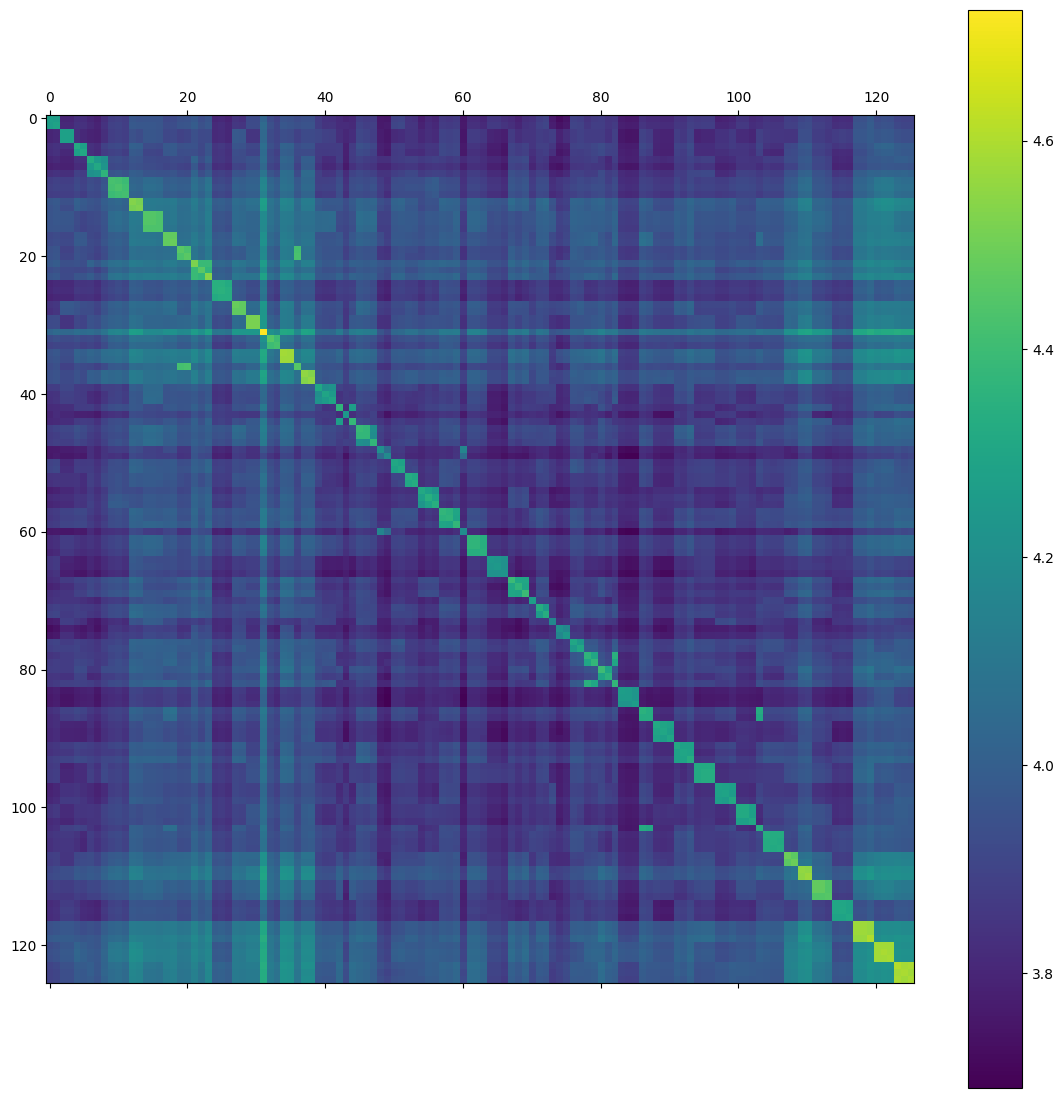

In [50]:
# plt.matshow(mi_matrix[:,:,12])


# alpha = ['BSL0201', 'BSL0202', 'BSL0203', 'NTL0401', 'NTL0402', 'NTL0403', 'NTL0801', 'NTL0802', 'NTL0803', 'ZRH0401', 'ZRH0402', 'ZRH0403']

data = mi_matrix[:,:,1]

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cax = ax.matshow(data)
fig.colorbar(cax)

# ax.set_xticklabels(alpha)
# ax.set_yticklabels(alpha)

# ax.set_xticks(np.arange(len(alpha)), labels=alpha)
# ax.set_yticks(np.arange(len(alpha)), labels=alpha)

fig.show()

(126, 126)


/tmp/ipykernel_13797/1107915850.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


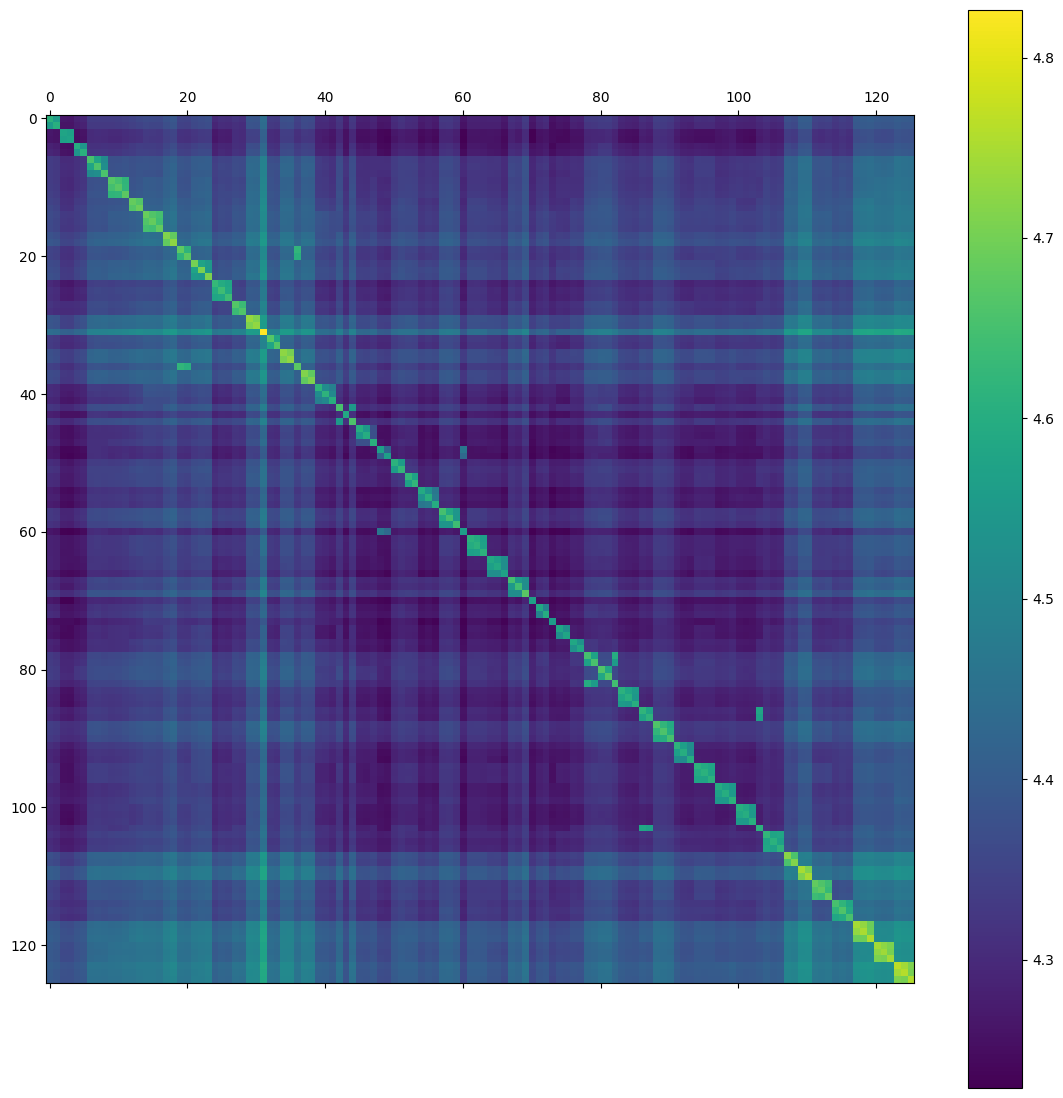

In [51]:
y = np.average(mi_matrix, axis=2)
print(y.shape)

# alpha = ['BSL0201', 'BSL0202', 'BSL0203', 'NTL0401', 'NTL0402', 'NTL0403', 'NTL0801', 'NTL0802', 'NTL0803', 'ZRH0401', 'ZRH0402', 'ZRH0403']

data = y

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cax = ax.matshow(data)
fig.colorbar(cax)

# ax.set_xticks(np.arange(len(alpha)), labels=alpha)
# ax.set_yticks(np.arange(len(alpha)), labels=alpha)

fig.show()

In [251]:
unique_ses_1, counts_ses_1 = np.unique(uae_values_ses_1, return_counts=True)
unique_ses_2, counts_ses_2 = np.unique(uae_values_ses_2, return_counts=True)
unique_pat_1_ses_1, counts_pat_1_ses_1 = np.unique(uae_values_pat_1_ses_1, return_counts=True)
unique_pat_1_ses_2, counts_pat_1_ses_2 = np.unique(uae_values_pat_1_ses_2, return_counts=True)

unique_pat_2_ses_1, counts_pat_2_ses_1 = np.unique(uae_values_pat_2_ses_1, return_counts=True)
unique_pat_2_ses_2, counts_pat_2_ses_2 = np.unique(uae_values_pat_2_ses_2, return_counts=True)

In [252]:
pdf_ses_1 = counts_ses_1/counts_ses_1.shape[0]
pdf_ses_2 = counts_ses_2/counts_ses_2.shape[0]
pdf_pat_1_ses_1 = counts_pat_1_ses_1/counts_pat_1_ses_1.shape[0]
pdf_pat_1_ses_2 = counts_pat_1_ses_2/counts_pat_1_ses_2.shape[0]

pdf_pat_2_ses_1 = counts_pat_2_ses_1/counts_pat_2_ses_1.shape[0]
pdf_pat_2_ses_2 = counts_pat_2_ses_2/counts_pat_2_ses_2.shape[0]

In [ ]:
print("KL of session 1 and session 2: ", sum(rel_entr(pdf_ses_1, pdf_ses_2[1:])))
print("KL of session 2 and session 1: ", sum(rel_entr(pdf_ses_2[1:], pdf_ses_1)))
print("KL of session 1 and patient 2 session 1: ", sum(rel_entr(pdf_ses_1, pdf_pat_1_ses_1[2:])))
print("KL of patient 2 session 1 and session 1: ", sum(rel_entr(pdf_pat_1_ses_1[2:], pdf_ses_1)))
print("KL of session 2 and patient 2 session 1: ", sum(rel_entr(pdf_ses_2, pdf_pat_1_ses_1[1:])))
print("KL of patient 2 session 1 and session 2: ", sum(rel_entr(pdf_pat_1_ses_1[1:], pdf_ses_2)))

print("KL of patient 2 session 1 and patient 2 session 2: ", sum(rel_entr(pdf_pat_1_ses_1, pdf_pat_1_ses_2[3:])))
print("KL of patient 2 session 2 and patient 2 session 1: ", sum(rel_entr(pdf_pat_1_ses_2[3:], pdf_pat_1_ses_1)))

print("KL of patient 3 session 1 and patient 3 session 2: ", sum(rel_entr(pdf_pat_2_ses_1, pdf_pat_2_ses_2[3:])))
print("KL of patient 3 session 2 and patient 3 session 1: ", sum(rel_entr(pdf_pat_2_ses_2[3:], pdf_pat_2_ses_1)))

print("KL of patient 3 session 1 and patient 1 session 1: ", sum(rel_entr(pdf_pat_2_ses_1[4:], pdf_ses_1)))
print("KL of patient 1 session 1 and patient 3 session 1: ", sum(rel_entr(pdf_ses_1, pdf_pat_2_ses_1[4:])))

print("KL of patient 3 session 1 and patient 2 session 1: ", sum(rel_entr(pdf_pat_2_ses_1[2:], pdf_pat_1_ses_1)))
print("KL of patient 2 session 1 and patient 3 session 1: ", sum(rel_entr(pdf_pat_1_ses_1, pdf_pat_2_ses_1[2:])))

In [260]:
pat_0_ses = list(pdf_ses_1.flatten()) + list(pdf_ses_2.flatten())

pat_1_ses = list(pdf_pat_1_ses_1.flatten()) + list(pdf_pat_1_ses_2.flatten())

pat_2_ses = list(pdf_pat_2_ses_1.flatten()) + list(pdf_pat_2_ses_2.flatten())

In [ ]:
len(pat_0_ses)

In [ ]:
bins = np.linspace(0, 0.2, 10)

plt.hist(pat_0_ses, bins, label='x')
plt.hist(pat_1_ses, bins, label='y')
plt.hist(pat_2_ses, bins, label='z')
plt.legend(loc='upper right')
plt.show()

In [ ]:
max(pdf_pat_1_ses_1)

In [ ]:
x[:,0]